### Telco Customer Churn
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

*Q0: Have a quick overview of the features and implement a “cleaning process”. Make sure this part of the code is well organised, if possible make this an object-oriented exercise.*

In [1]:
#Import necessary dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import numpy as np
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df1 = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# check for null values in the dataset
df.isna().sum().sum()

0

In [5]:
df.nunique().sort_values()

Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PaperlessBilling       2
PhoneService           2
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
DeviceProtection       3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6531
customerID          7043
dtype: int64

In [6]:
# Based on the above, all columns are categorical except for Tenure, Monthly Charges, Total Charges
cols = ['Churn', 'gender', 'SeniorCitizen','Partner', 'Dependents', 'PaperlessBilling', 'PhoneService','Contract','StreamingMovies','StreamingTV','TechSupport','OnlineBackup','OnlineSecurity','InternetService', 'MultipleLines', 'DeviceProtection', 'PaymentMethod']
for col in cols:
    print (col,':', df[col].unique())

Churn : ['No' 'Yes']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PaperlessBilling : ['Yes' 'No']
PhoneService : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
StreamingMovies : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
OnlineSecurity : ['No' 'Yes' 'No internet service']
InternetService : ['DSL' 'Fiber optic' 'No']
MultipleLines : ['No phone service' 'No' 'Yes']
DeviceProtection : ['No' 'Yes' 'No internet service']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


The classification variables can divided into 3 groups:

1) Yes/No classification variables (Partner, dependent, ...etc) 

2) Yes/No/Other classification variables (StreamingMovies, TechSupport, ..etc)

3) Classification variables with other values (gender, contract, etc.) 


In [7]:
# we convert SeniorCitizen to Yes/No in order to plot it with the other Yes/No columns 
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'}) 

# For these columns we expect yes/no values only 
cols1 = ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']  

# For these columns we expect yes/no or a different value such as 'no internet service', or 'special package'
cols2 = ['StreamingMovies','StreamingTV','TechSupport','OnlineBackup','OnlineSecurity', 
         'MultipleLines', 'DeviceProtection']

# For these columns, we expect values other than yes/no
cols3 = ['gender','Contract','InternetService','PaymentMethod']

In [8]:
def plot_chart(cols,fz=(12,10), rot=0):
    fig, axes = plt.subplots(nrows=2, ncols=(len(cols)+1)//2, figsize=fz)
    for i, col in enumerate(cols):
        sns.countplot(x=col, data=df, ax=axes[i%2,i//2], order=df[col].value_counts().index)
        axes[i%2,i//2].set_title(col)
        axes[i%2,i//2].set_xlabel(None)
        axes[i%2,i//2].set_ylabel(None)
        xlabels = axes[i%2,i//2].get_xticklabels()
        axes[i%2,i//2].set_xticklabels(xlabels, rotation=rot)
 
    for i in range(len(cols), len(axes.flatten()) ):
        fig.delaxes(axes.flatten()[i])

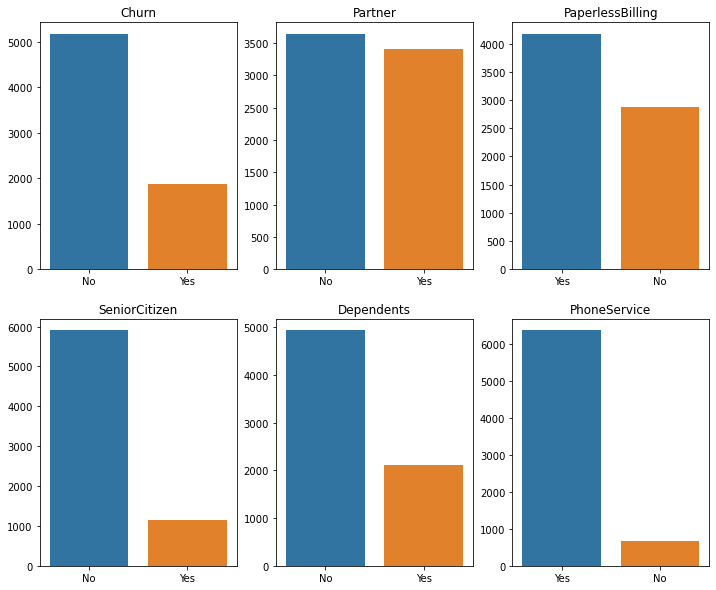

In [9]:
# Plot the first type - accept only Yes/No
plot_chart(cols1)

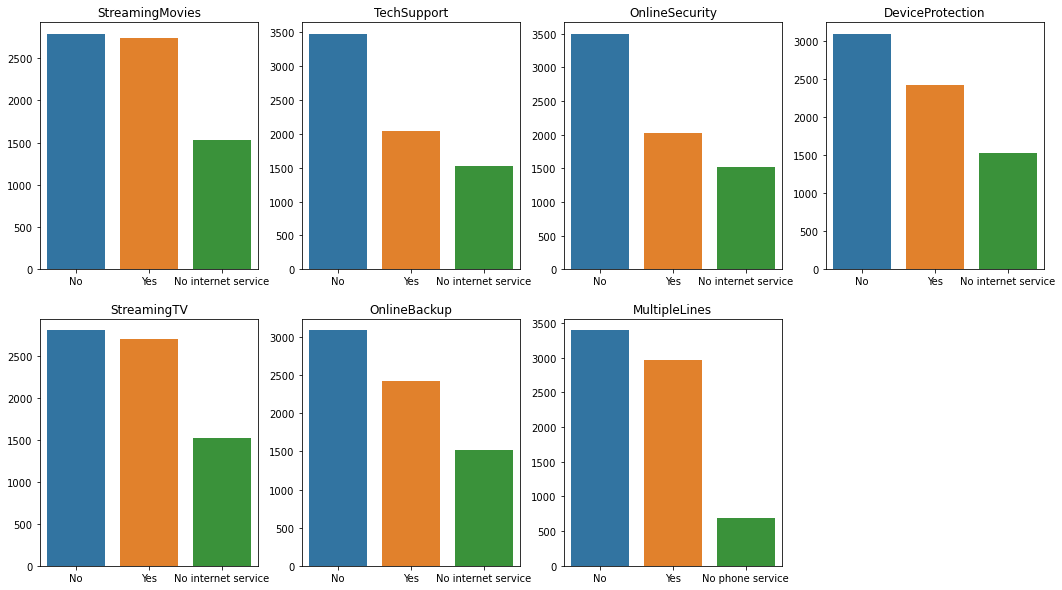

In [10]:
# plot bar charts 
plot_chart(cols2,(18,10))

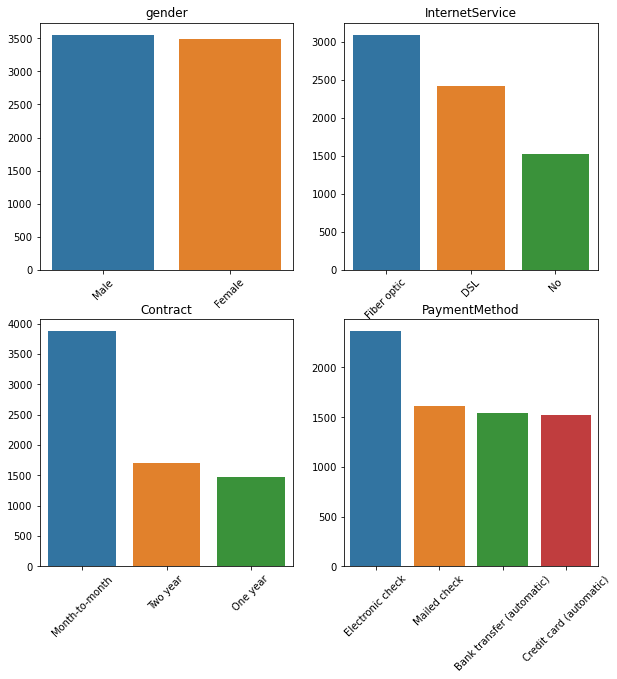

In [11]:
# plot bar charts 
plot_chart(cols3,(10,10),45)

In [12]:
# TotalCharges is showing blank when the balance is Null so will replace it to '0' then convert the column to float 
df[df['TotalCharges'] == ' '].shape

(11, 21)

In [13]:
# convert empty values to 0 and convert TotalCharges to Numeric
df['TotalCharges'] = df['TotalCharges'].str.replace (' ','0')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [14]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


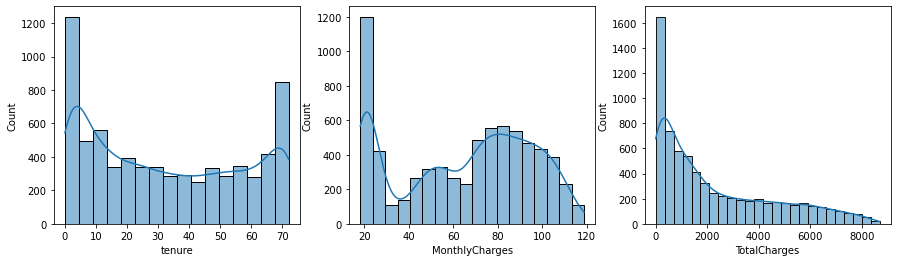

In [15]:
# now we look at the numeric values 
ncols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
for i, col in enumerate(ncols): 
    sns.histplot(df[col], kde=True, ax=axes[i])

*Q1: Explain the process that needs to happen for each feature before you train your model. Also, think about how future observations might be different from the ones you have! Be creative.*

We need to convert all the classification variables to numbers to be used in the prediction models. This can be done by assigning numerical values for each of the categorical feature we have in the dataset. 

1) Yes/No classification variables - cannot accept values other than Yes/No.

2) Yes/No/'Others' classification variables - can accept values other than Yes/No

3) Classification variables with other values (gender, contract, etc.) - can accept any value


In [16]:
#df= df1.copy()

def mapping_dict(col, yes_no=True):
    md = {}
    if (yes_no == True):
        md = {'No': 0, 'Yes': 1}
    val = col.unique()
    if len(md)==0:
        cnt=0
    else:
        cnt=max(md.values())+1
    for i in val:
        if not(i in md.keys()):
            md[i] = cnt
            cnt+=1
    return md

In [17]:
#For first group : convert category values to numbers 
for col in cols1:
    md = mapping_dict(df[col])
    df[col] = df[col].map(md)

    # for any value other than Yes/No, identify these values, flag and remove them 
    lst = [x for x in md.keys() if x not in ['Yes','No']]
    if (len(lst)>0):
        print ('The following values in',col,'cannot be accepted and needs to be revised : ', lst)
        print (df[df[col]>1].shape[0], 'rows removed from the dataset' )
        df = df[df[col]<=1]


In [18]:
# for second group : convert category values to numbers and accept any value for these columns
for col in cols2:
    md = mapping_dict(df[col])
    df[col] = df[col].map(md)

In [19]:
# We use patterns to identify males & females based on first letter - covert it to Male / Female  
print (df['gender'].value_counts())
df.loc[df['gender'].str.contains(r'^[Mm]'),'gender']='Male'
df.loc[df['gender'].str.contains(r'^[Ff]'),'gender']='Female'

# for any value other than Male/Female, itdentify these values, flag it and remove them 
lst = [x for x in list(df['gender'].unique()) if x not in ['Male','Female']]
if (len(lst)>0):
    print ('The following values in gender to be revised : ', lst)
    print (df[~df['gender'].isin(['Male','Female'])].shape[0], 'rows removed from the dataset' )
    df = df[df['gender'].isin(['Male','Female'])]

Male      3555
Female    3488
Name: gender, dtype: int64


In [20]:
# for third group : convert category values to numbers and accept any value for these columns
for col in cols3:
    md = mapping_dict(df[col], yes_no=False)
    df[col] = df[col].map(md)

df['gender'].value_counts()    

1    3555
0    3488
Name: gender, dtype: int64

In [21]:
for col in cols:
    print (col,': before -', list(df1[col].value_counts()), '&  after -', list(df[col].value_counts()))

Churn : before - [5174, 1869] &  after - [5174, 1869]
gender : before - [3555, 3488] &  after - [3555, 3488]
SeniorCitizen : before - [5901, 1142] &  after - [5901, 1142]
Partner : before - [3641, 3402] &  after - [3641, 3402]
Dependents : before - [4933, 2110] &  after - [4933, 2110]
PaperlessBilling : before - [4171, 2872] &  after - [4171, 2872]
PhoneService : before - [6361, 682] &  after - [6361, 682]
Contract : before - [3875, 1695, 1473] &  after - [3875, 1695, 1473]
StreamingMovies : before - [2785, 2732, 1526] &  after - [2785, 2732, 1526]
StreamingTV : before - [2810, 2707, 1526] &  after - [2810, 2707, 1526]
TechSupport : before - [3473, 2044, 1526] &  after - [3473, 2044, 1526]
OnlineBackup : before - [3088, 2429, 1526] &  after - [3088, 2429, 1526]
OnlineSecurity : before - [3498, 2019, 1526] &  after - [3498, 2019, 1526]
InternetService : before - [3096, 2421, 1526] &  after - [3096, 2421, 1526]
MultipleLines : before - [3390, 2971, 682] &  after - [3390, 2971, 682]
Devic

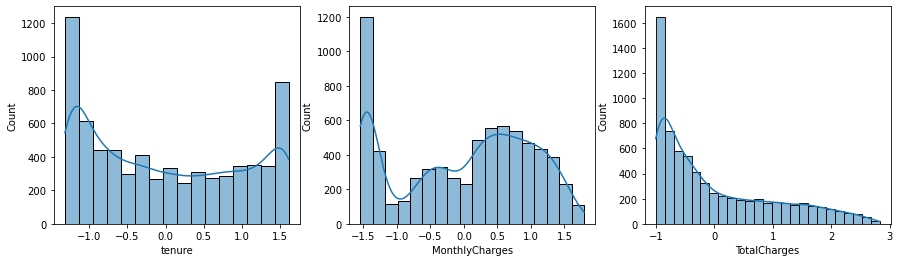

In [22]:
# Normalize Numeric Value
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
for i, col in enumerate(ncols): 
    df[col] = (df[col] - df[col].mean()) / (df[col].std())
    sns.histplot(df[col], kde=True, ax=axes[i])

In [23]:
# customerID is not required for the prediction model
df = df.drop(['customerID'],axis = 1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [25]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277354,0,2,0,0,1,0,0,0,0,0,1,0,-1.160241,-0.992540,0
1,1,0,0,0,0.066323,1,0,0,1,0,1,0,0,0,1,0,1,-0.259611,-0.172152,0
2,1,0,0,0,-1.236636,1,0,0,1,1,0,0,0,0,0,1,1,-0.362635,-0.957998,1
3,1,0,0,0,0.514215,0,2,0,1,0,1,1,0,0,1,0,2,-0.746482,-0.193659,0
4,0,0,0,0,-1.236636,1,0,1,0,0,0,0,0,0,0,1,0,0.197351,-0.938808,1


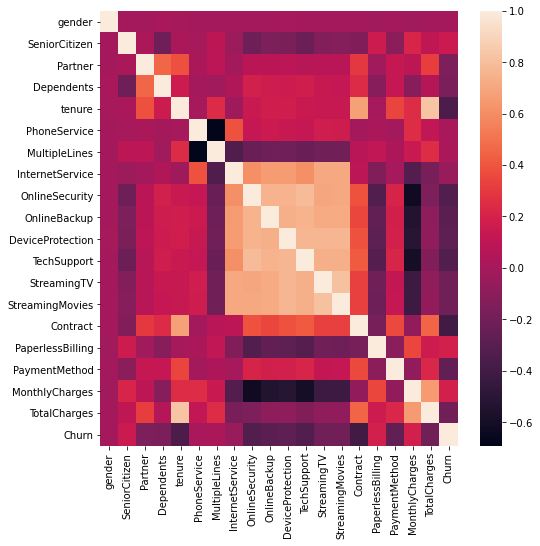

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr())

From the heatmap above, judging from the features with significant correlation coefficients of higher than 0.8, customer with internet access will normally have other online services as well such as online security, backup, tech support, streaming movies, etc.

*Q2: Choose one metric to evaluate the different models you will train and explain why you are choosing that instead of other metrics. You can try a few base models but model performance is not of prime importance yet.*

Precision measures how precise/accurate the model is out of those predicted positive, how many of them are actual positive. Precision is a good measure when the costs of False Positive is high.

While recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. We are aware of the fact that we are trading off between the false positive and false negative ratio.

To the company, with high false negative rate we will falsely believe that the customer will stay but they are actually leaving so we will not take actions in time. In our model, the cost of not identifying the clients who will churn is the lost revenue after losing them. While the cost of flagging customers who are not planning to leave incorrectly could be calling them to check on their satisfaction level and perphaps offering them some incentives to pertain them with the company's services.

Assuming that the cost of losing clients is higher, we will use recall to evaluate our model. 

In [27]:
# Def X and Y
y = df['Churn']
X = df.drop('Churn', axis=1)

In [28]:
# split the dataset to train and test the model 
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print (X_train.shape)
print (X_test.shape)

(5634, 19)
(1409, 19)


#### 2. Using K Neighbors Classifier

In [29]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('k_neighbors', KNeighborsClassifier())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'k_neighbors__n_neighbors':np.arange(5,50)}

# Create the GridSearchCV object: knn
knn_cv = GridSearchCV(pipeline,param_grid=parameters,cv=5)

# Fit to the training set
knn_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % knn_cv.best_score_)
print('Best Hyperparameters: %s' % knn_cv.best_params_)

Best Score: 0.7916220778217843
Best Hyperparameters: {'k_neighbors__n_neighbors': 32}


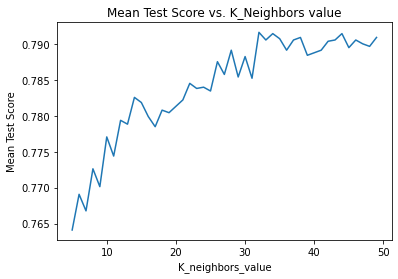

In [30]:
# Plot the mean_test_score values (after 5-fold CV) versus k_neighbors from 5 to 50 curve
x1 = np.arange(5,50)
y1 = knn_cv.cv_results_['mean_test_score']
plt.plot(x1,y1)
plt.xlabel('K_neighbors_value')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. K_Neighbors value')
plt.show()

In [31]:
# Run the model using the best paramter
knn = knn_cv.best_estimator_
# Fit to the training set
knn.fit(X_train,y_train)

#Make the prediction:
y_pred1 = knn.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.65      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



[[926 110]
 [169 204]]


Text(0.5, 1.0, 'Confusion Matrix')

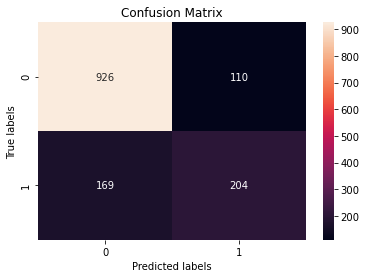

In [32]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred1)
print (cm)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [33]:
# since our objective is to improve the recall ratio - we will change the threshold to see the impact 
y.value_counts()/len(y)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Text(0.5, 1.0, 'Confusion Matrix')

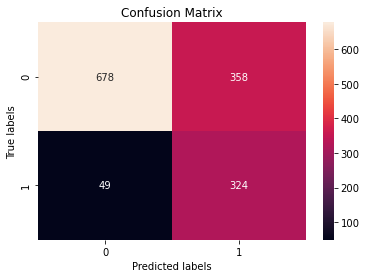

In [34]:
# Compute predicted probabilities: y_pred_prob for KNN
y_pred_prob1 = knn.predict_proba(X_test)[:,1]

# assuming the threshold of 0.26
y_pred_new1 = np.where(y_pred_prob1 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new1)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [35]:
#We improved the recall ratio but the precision decreased
print(classification_report(y_test, y_pred_new1))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1036
           1       0.48      0.87      0.61       373

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.73      1409



#### 2. Using Logistic Regression 

In [36]:
# Setup the pipeline steps: steps
steps2 = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

# Create the pipeline: pipeline 
pipeline2 = Pipeline(steps2)

# Specify the hyperparameter space
c_space = np.logspace(-5, 8, 15)
param_grid = {'logreg__C': c_space}

# Create the GridSearchCV object: logreg
logreg_cv = GridSearchCV(pipeline2,param_grid,cv=5)

# Fit to the training set
logreg_cv.fit(X_train,y_train)

# Compute and print the metrics
print('Best Score: %s' % logreg_cv.best_score_)
print('Best Hyperparameters: %s' % logreg_cv.best_params_)

Best Score: 0.7997873919820458
Best Hyperparameters: {'logreg__C': 31.622776601683793}


In [37]:
logreg = logreg_cv.best_estimator_
# Fit to the training set
logreg.fit(X_train,y_train)

#Make the prediction:
y_pred2 = logreg.predict (X_test)

#Classification report
print (classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



Text(0.5, 1.0, 'Confusion Matrix')

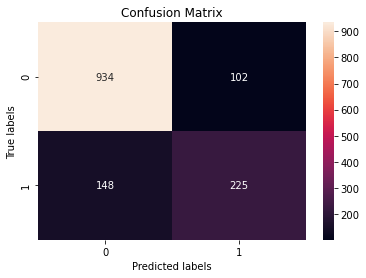

In [38]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred2)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

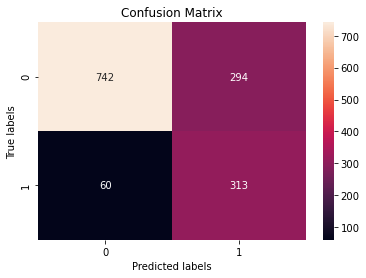

In [39]:
# Compute predicted probabilities: y_pred_prob for logreg
y_pred_prob2 = logreg_cv.predict_proba(X_test)[:,1]

#we applied the same threshold as per the KNN model
y_pred_new2 = np.where(y_pred_prob2 >=0.26, 1, 0)

cm1 = confusion_matrix(y_test, y_pred_new2)
ax = plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [40]:
#We improved the recall ratio but the precision decreased
print(classification_report(y_test, y_pred_new2))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.82      0.75      0.76      1409



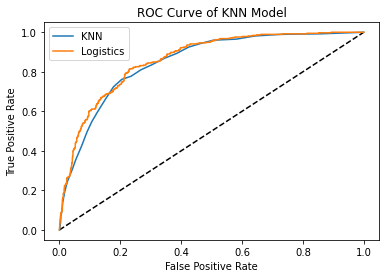

In [41]:
# Generate ROC curve values: fpr, tpr, thresholds for each model to plot
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='KNN')
plt.plot(fpr2, tpr2, label='Logistics')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of KNN Model')
plt.legend()
plt.show()

We can see that from the ROC curve, the Logistics Regression model produces a better prediction than the KNN model in terms of overall performance in both precision and recall.